In [1]:
cd ..

/workspaces/language-api


/root/.local/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import pandas as pd
import numpy as np 
import ast
from plotnine import *
from itertools import permutations
from sacrebleu.metrics import BLEU
from sacrebleu import sentence_bleu
from src.models.pretrained import load_models, parallel_translation
import time
import os

/usr/local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
/usr/local/lib/python3.12/site-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.


## Read metadata

In [3]:
with open('data/train.metadata') as f:
    metadata = f.readlines()
    
metadata = [ast.literal_eval(line.strip()) for line in metadata]
metadata_df = pd.DataFrame(metadata)

### Metadata sizes

In [4]:
language_pairs_qty = metadata_df.groupby(['src_lang', 'tgt_lang']).size().reset_index().rename(columns={0:'obs'})
language_pairs_qty['language_pair'] = language_pairs_qty['src_lang'] + ' - ' + language_pairs_qty['tgt_lang']
language_pairs_qty.sort_values(by='obs')

,src_lang,tgt_lang,obs,language_pair
10,sv,en,89513,sv - en
4,en,nb,89786,en - nb
9,sv,da,93665,sv - da
7,nb,en,99447,nb - en
0,da,en,103097,da - en
3,en,da,108729,en - da
5,en,sv,139502,en - sv
8,nb,sv,141412,nb - sv
1,da,nb,150826,da - nb
11,sv,nb,152931,sv - nb


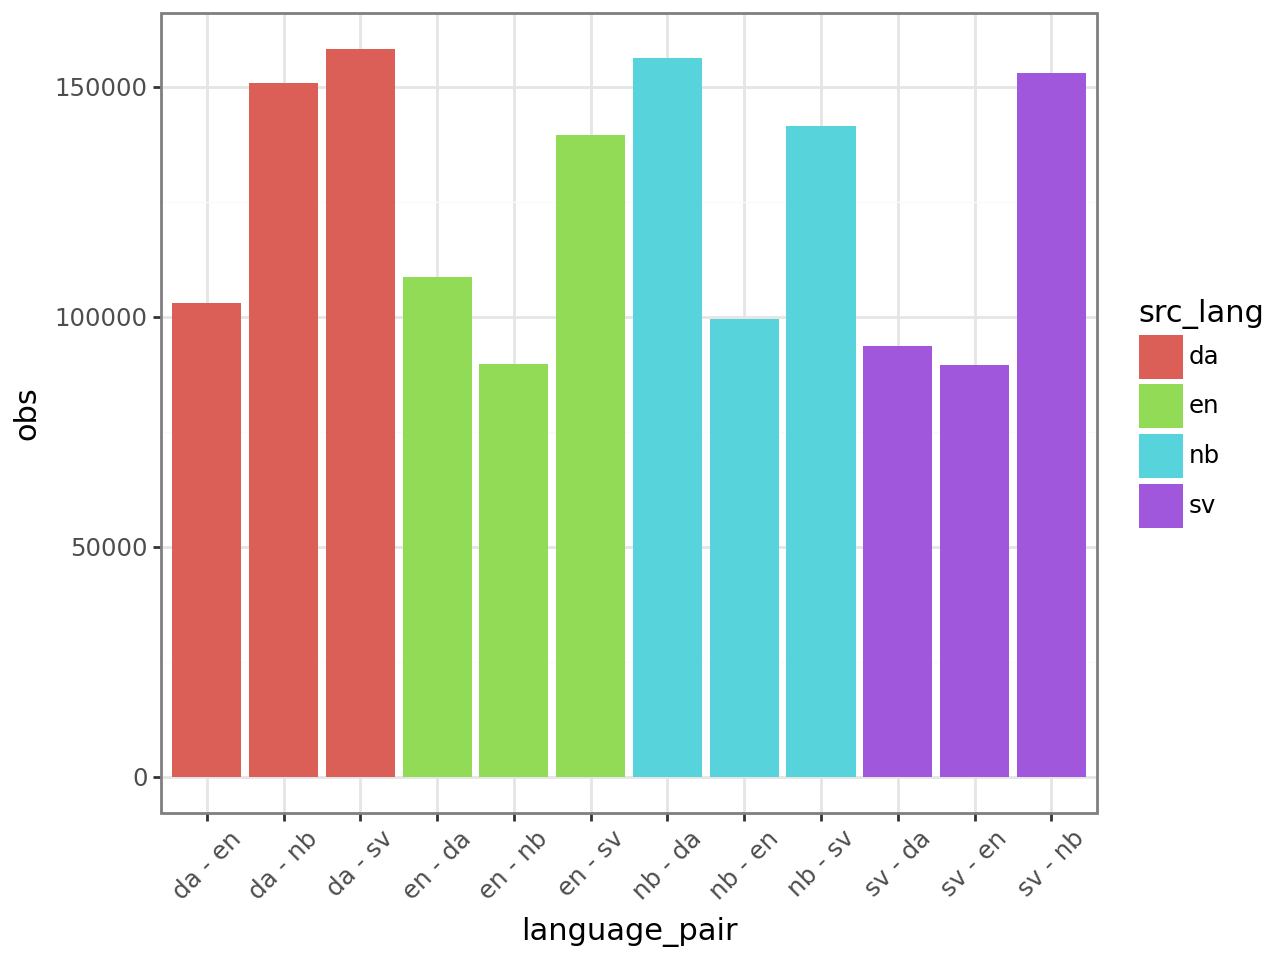

In [5]:
(
    ggplot(language_pairs_qty, aes(x='language_pair', y='obs', fill='src_lang')) +
    geom_bar(stat='identity') +
    theme_bw() + 
    theme(axis_text_x= element_text(angle=45))
    
)

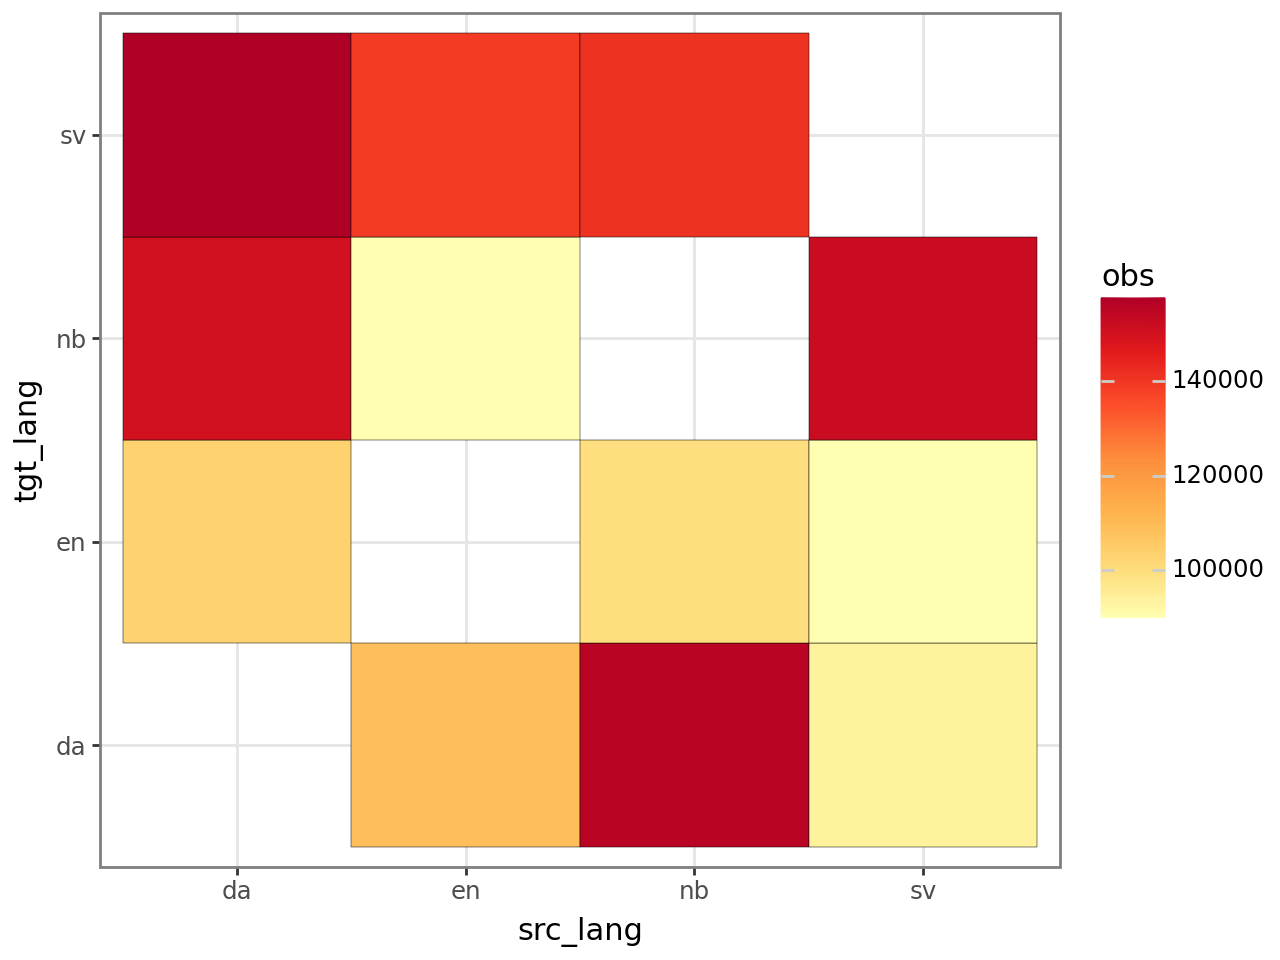

In [6]:
(
    ggplot(language_pairs_qty, aes(x='src_lang', y='tgt_lang', fill='obs')) +
    geom_tile(color='black') +
    scale_fill_distiller(palette='YlOrRd', 
                         limits=[language_pairs_qty['obs'].min(), language_pairs_qty['obs'].max()],
                         direction=1) +
    theme_bw()
    
)

## Data distribution

In [7]:
languages = ('en', 'da', 'sv', 'nb')
language_pairs = list(permutations(languages, 2))

sample_indices = pd.DataFrame()
sample_size = 5000
for src, tgt in language_pairs:
    pair_indices = metadata_df.loc[(metadata_df['src_lang'] == src) & (metadata_df['tgt_lang'] == tgt)].sample(n=5000, random_state=0)
    sample_indices = pd.concat([sample_indices, pair_indices])
    


## Distributions (lens, characters, etc)

In [8]:
with open('data/train.src', 'r') as f:
    train_src = f.readlines()

with open('data/train.tgt', 'r') as f:
    train_tgt = f.readlines()

In [9]:
translation_df = metadata_df.copy()
translation_df['src_text'] = train_src
translation_df['tgt_text'] = train_tgt

# Strip trailing spaces
translation_df['src_text'] = translation_df['src_text'].str.strip()
translation_df['tgt_text'] = translation_df['tgt_text'].str.strip()

# Compute character lens
translation_df['src_len'] = translation_df['src_text'].str.len()
translation_df['tgt_len'] = translation_df['tgt_text'].str.len()

In [10]:
translation_df[['src_len', 'tgt_len']].corr()

,src_len,tgt_len
src_len,1.000000,0.979144
tgt_len,0.979144,1.000000


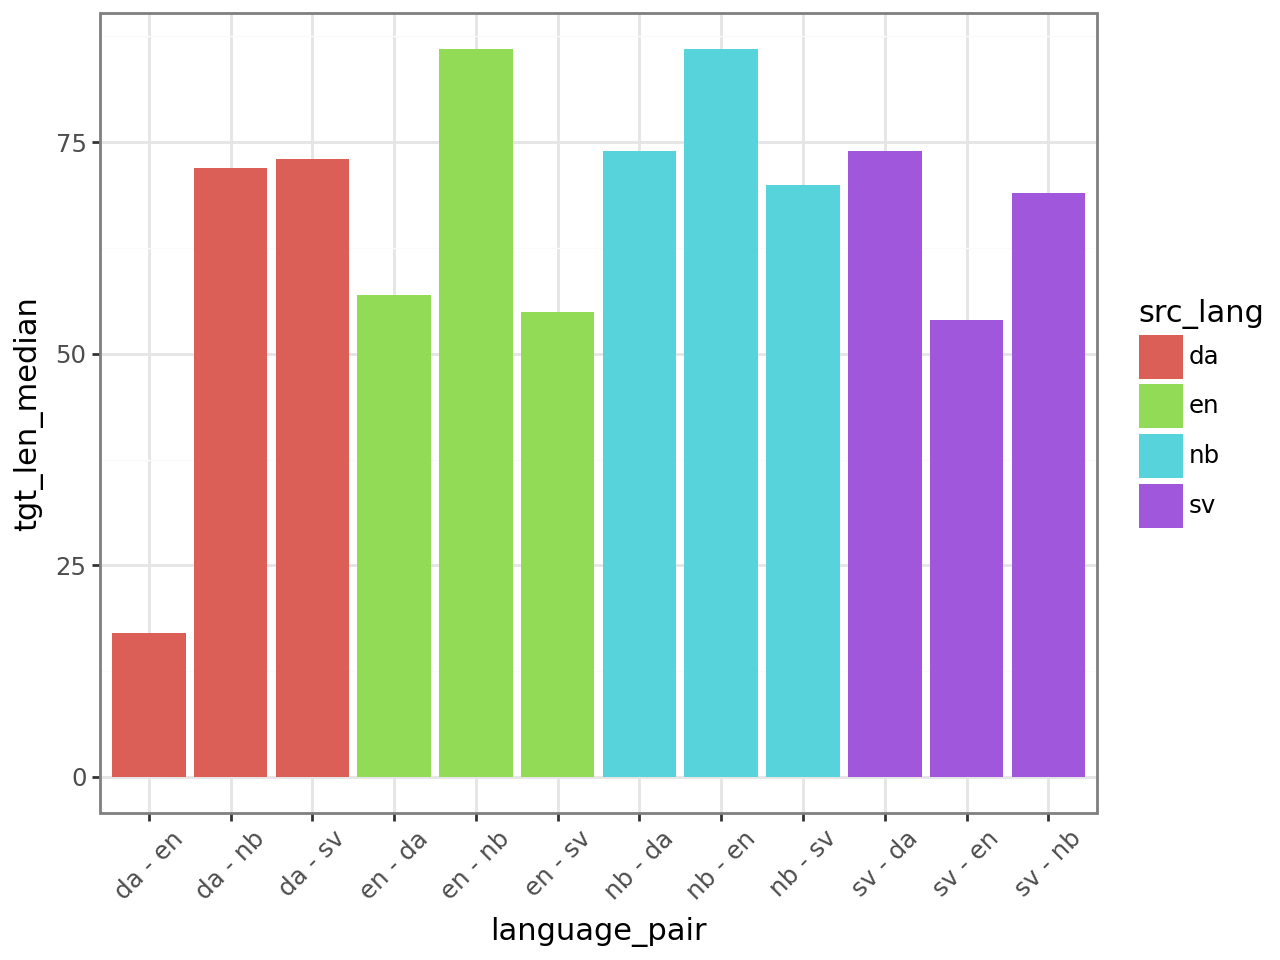

In [11]:
# Aggregate
len_distribution_df = (translation_df
 .groupby(['src_lang', 'tgt_lang'])[['src_len', 'tgt_len']]
 .agg(['mean', 'median', 'min', 'max', ('p90', lambda x: np.quantile(x, 0.95))])
 .reset_index()
)
len_distribution_df.columns=[col[0] if col[1]=='' else '_'.join(col) for col in len_distribution_df.columns]
len_distribution_df['language_pair'] = len_distribution_df['src_lang'] + ' - ' + len_distribution_df['tgt_lang']

(
    ggplot(len_distribution_df, aes(x='language_pair', y='tgt_len_median', fill='src_lang')) +
    geom_bar(stat='identity') +
    theme_bw() + 
    theme(axis_text_x= element_text(angle=45))
    
)

In [12]:
translation_df['src_tokens'] = translation_df['src_text'].str.split().apply(len)
translation_df['tgt_tokens'] = translation_df['tgt_text'].str.split().apply(len)

In [13]:
translation_df.groupby(['src_lang', 'tgt_lang'])[['src_tokens', 'tgt_tokens']].agg(['median', ('p90', lambda x: np.quantile(x, 0.9))])

src_tokens       tgt_tokens      
                      median   p90     median   p90
src_lang tgt_lang                                  
da       en              2.0  36.0        3.0  37.0
         nb             12.0  26.0       12.0  26.0
         sv             12.0  28.0       12.0  27.0
en       da              9.0  43.0        9.0  41.0
         nb             14.0  29.0       14.0  28.0
         sv             10.0  26.0       10.0  24.0
nb       da             12.0  26.0       12.0  26.0
         en             14.0  28.0       14.0  29.0
         sv             12.0  26.0       11.0  25.0
sv       da             12.0  27.0       12.0  28.0
         en              9.0  24.0       10.0  26.0
         nb             11.0  25.0       12.0  26.0

## BLEU scores for samples

To compute BLEU score for each pair, we use a Kaggle GPU. Below are the results of the translations tables

In [16]:
translation_df.to_parquet('data/translation_merged.parquet', index=False)

In [14]:
# Get src and tgt language pairs
cache_path: str = "/cached_models/marianmodels/"
marian_en_da = load_models(language_pair=('en', 'da'), cache_path=cache_path)

/usr/local/lib/python3.12/site-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.


In [15]:
tokenizer, model = marian_en_da.values()
model.eval()

MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(58930, 512, padding_idx=58929)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(58930, 512, padding_idx=58929)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLU()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,), eps=1e-05

In [16]:
en_da_translations = translation_df.loc[(translation_df['src_lang']=='en') & (translation_df['tgt_lang']=='da')]

# WATCH OUT FOR BIG DIFFERENCES IN LENGTHS

In [17]:
sample_en_da_translations = en_da_translations.head(100)
src_text = sample_en_da_translations['src_text'].tolist()

In [23]:
batch_size = 10
tokenized_batches = [(i, tokenizer(src_text[i:(i+batch_size)], return_tensors="pt", padding=True)) for i in range(0, len(src_text), batch_size) ]

In [24]:
from multiprocessing import Pool
from functools import partial

parallel_translation_en_da = partial(parallel_translation, model=model)

In [25]:
from torch.multiprocessing import Pool, Process, set_start_method


In [ ]:
if __name__ == "__main__":
    result = []
    multi_pool = Pool(processes=3)
    predictions = multi_pool.map(parallel_translation_en_da, tokenized_batches)
    multi_pool.close()
    multi_pool.join()
    print(predictions)

In [ ]:
if __name__ == "__main__":
    mp_context = NoDaemonContext()
    # compute(query, context=context)
    with mp_context.Pool(8) as pool:
        async_res = pool.apply_async(parallel_translation_en_da, tokenized_batches)
        
        

In [34]:
t1 = time.time()
generated_text = 
t2 = time.time()
print((t2 - t1)/60)

1.4396934191385904


In [34]:
model.batc

TypeError: MarianTokenizer.batch_decode() missing 1 required positional argument: 'sequences'

In [108]:
def translate_text(src_text:str, model, tokenizer) -> str:
    translated = model.generate(
        **tokenizer(src_text, return_tensors="pt", padding=True)
    )
    translated_text = [
        tokenizer.decode(t, skip_special_tokens=True) for t in translated
    ][0]

    return translated_text


In [119]:
en_da_translations_sample = en_da_translations.sample(1000, random_state=12).copy()
en_da_translations['marian_translation'] = en_da_translations['src_text'].apply(lambda x: translate_text(x, model=model, tokenizer=tokenizer))

KeyboardInterrupt: 

In [118]:
t1 = time.time()
en_da_translations_sample['marian_translation'] = (en_da_translations_sample['src_text']
                                                   .apply(lambda x: translate_text(x, model=model, tokenizer=tokenizer))
                                                  )
t2 = time.time()
print((t2-t1)/60, ' minutes')

1.1644099831581116  seconds


In [100]:
translated = model.generate(
    **tokenizer(row['src_text'].iloc[0], return_tensors="pt", padding=True)
)
translated_text = [
    tokenizer.decode(t, skip_special_tokens=True) for t in translated
][0]


In [101]:
print(row['src_text'].iloc[0])

For the lucky few could wear the narrow dresses, it was a fashion that afforded a greater range of movement than women's clothes had allowed for centuries.


In [102]:
print(translated_text, '\n-----------\n', row['tgt_text'].iloc[0])

For de heldige få kunne bære de smalle kjoler, var det en mode, der gav en større vifte af bevægelse end kvinders tøj havde tilladt i århundreder. 
-----------
 For de heldige, som kunne bære de smalle kjoler, var der tale om en mode, som sikrede større bevægelsesfrihed, end kvindetøj havde givet mulighed for i mange århundreder.


In [103]:
sentence_bleu(translated_text, [row['tgt_text'].iloc[0]])

BLEU = 28.15 66.7/37.9/25.0/14.8 (BP = 0.905 ratio = 0.909 hyp_len = 30 ref_len = 33)

In [77]:
?sentence_bleu

Signature:
sentence_bleu(
    hypothesis: str,
    references: Sequence[str],
    smooth_method: str = 'exp',
    smooth_value: Optional[float] = None,
    lowercase: bool = False,
    tokenize='13a',
    use_effective_order: bool = True,
) -> sacrebleu.metrics.bleu.BLEUScore
Docstring:
Computes BLEU for a single sentence against a single (or multiple) reference(s).

Disclaimer: Computing BLEU at the sentence level is not its intended use as
BLEU is a corpus-level metric.

:param hypothesis: A single hypothesis string.
:param references: A sequence of reference strings.
:param smooth_method: The smoothing method to use ('floor', 'add-k', 'exp' or 'none')
:param smooth_value: The smoothing value for `floor` and `add-k` methods. `None` falls back to default value.
:param lowercase: Lowercase the data
:param tokenize: The tokenizer to use
:param use_effective_order: Don't take into account n-gram orders without any match.
:return: Returns a `BLEUScore` object.
File:      /usr/local/lib/py